# **1. Data Preprocessig**

In [1]:
import nltk
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from keras.preprocessing.text import Tokenizer
import string
import tensorflow as tf

import spacy
from keras.layers import Embedding, Input, Dot, Reshape, LSTM, Dense, TimeDistributed, Concatenate, Bidirectional, Flatten, Activation, RepeatVector, Permute, Lambda
from tensorflow.keras.layers import Multiply
from keras.models import Model
from sklearn.utils import shuffle
from tensorflow.keras import backend as K

import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
!pip install nltk

In [3]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
# Read the data into a Pandas DataFrame 
data = pd.read_csv('/kaggle/input/eng2urdu/DataRNN.txt', delimiter = "\t", names = ['English','Urdu', 'reference'],  header=None)

In [6]:
data.head()

,English,Urdu,reference
0,Help!,مدد۔,CC-BY 2.0 (France) Attribution: tatoeba.org #4...
1,We won.,ہم جیت گئے۔,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
2,Beat it.,بھاگ جائو۔,CC-BY 2.0 (France) Attribution: tatoeba.org #3...
3,Beat it.,دفعہ ہو جائو۔,CC-BY 2.0 (France) Attribution: tatoeba.org #3...
4,We lost.,ہم ہار گئے۔,CC-BY 2.0 (France) Attribution: tatoeba.org #2...


In [7]:
data.drop('reference', axis=1, inplace=True)

In [8]:
data.head(100)

,English,Urdu
0,Help!,مدد۔
1,We won.,ہم جیت گئے۔
2,Beat it.,بھاگ جائو۔
3,Beat it.,دفعہ ہو جائو۔
4,We lost.,ہم ہار گئے۔
...,...,...
95,I like sports.,مجھے کھیل پسند ہے۔
96,I love movies.,مجھے فلمیں پسند ہے۔
97,It won't work.,یہ کام نہیں کرے گا۔
98,Tom hates you.,ٹام تم سے نفرت کرتا ہے۔


In [9]:
# Lowercase the text and remove punctuation
data['English'] = data['English'].apply(lambda x: x.lower())
data['English'] = data['English'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
data['Urdu'] = data['Urdu'].apply(lambda x: x.lower())
data['Urdu'] = data['Urdu'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

In [10]:
# Tokenize the text
data['English'] = data['English'].apply(lambda x: word_tokenize(x))
data['Urdu'] = data['Urdu'].apply(lambda x: word_tokenize(x))

In [11]:
# Remove stop words
stop_words = set(stopwords.words('english'))
data['English'] = data['English'].apply(lambda x: [word for word in x if word not in stop_words])
stop_words = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'        #set(stopwords.words('urdu'))
data['Urdu'] = data['Urdu'].apply(lambda x: [word for word in x if word not in stop_words])

In [12]:
# # Create vocabulary sets
# english_tokenizer = Tokenizer()
# english_tokenizer.fit_on_texts(data['English'])
# english_vocab_size = len(english_tokenizer.word_index) + 1

english_tokenizer = Tokenizer(oov_token="<OOV>")
english_tokenizer.fit_on_texts(data['English'])
english_vocab_size = len(english_tokenizer.word_index) + 1

urdu_tokenizer = Tokenizer(oov_token="<OOV>")
urdu_tokenizer.fit_on_texts(data['Urdu'])
urdu_vocab_size = len(urdu_tokenizer.word_index) + 1

In [13]:
print(english_vocab_size)
print(urdu_vocab_size)

1220
1712


In [14]:
# Convert the text to sequences of integers
english_sequences = english_tokenizer.texts_to_sequences(data['English'])
urdu_sequences = urdu_tokenizer.texts_to_sequences(data['Urdu'])

In [15]:
data = shuffle(data)
data.head(10)

,English,Urdu
6659,"[people, live, 100, years, old]","[بہت, کم, لوگ, ۱۰۰, سال, کی, عمر, تک, زندہ, رہ..."
4323,"[know, use, dictionary]","[تمہیں, پتہ, ہے, کی, لغت, استعمال, کیسے, کرتے,..."
10387,"[wish, hadnt, told, story, mother]","[کاش, تم, نے, وہ, کہانی, میری, امی, کو, نہ, بت..."
2686,[going],"[آپ, کس, کے, ساتھ, جا, رہی, ہے؟]"
6821,"[saying, two, different, things]","[کہنے, میں, اور, کرنے, میں, بڑا, فرق, ہے۔]"
8227,[lets],"[چلو, یہ, کرتے, ہیں۔]"
5656,"[young, children, dont, know, many, words]","[چھوٹے, بچے, زیادہ, الفاظ, نہیں, جانتے۔]"
3272,"[washed, hands, whole, business]","[میں, نے, اس, کاروبار, سے, اپنے, ہاتھ, صاف, کر..."
9251,"[wait, little, please, hasnt, arrived, yet]","[برائے, مہربانی, تھوڑا, انتظار, فرما, لے۔, وہ,..."
4205,"[bicycle, needs, repaired]","[میری, بائسیکل, کو, مرمت, کی, ضرورت, ہے۔]"


In [16]:
empty_tokens = []
for tokens in data['English']:
    if "" in tokens:
        empty_tokens.append(tokens)

print(tokens.count(empty_tokens))

0


# **2. Data Statistics:**

In [17]:
# Number of samples
n_samples = data.shape[0]

# Number of unique input tokens
n_unique_input_tokens = english_vocab_size

# Number of unique output tokens
n_unique_output_tokens = urdu_vocab_size

# Max sequence length for inputs
max_input_length = max([len(sequence) for sequence in english_sequences])

# Max sequence length for outputs
max_output_length = max([len(sequence) for sequence in urdu_sequences])

print("Number of samples:", n_samples)
print("Number of unique input tokens:", n_unique_input_tokens)
print("Number of unique output tokens:", n_unique_output_tokens)
print("Max sequence length for inputs:", max_input_length)
print("Max sequence length for outputs:", max_output_length)

Number of samples: 10503
Number of unique input tokens: 1220
Number of unique output tokens: 1712
Max sequence length for inputs: 9
Max sequence length for outputs: 21


In [18]:
data['English'].shape == data['Urdu'].shape

True

In [19]:
data['English'][567]

['bought', 'sister', 'new', 'hat']

# **3. Model Architecture**

For a given task, i am using an attention-based 
sequence-to-sequence model with an encoder-decoder architecture as instructed.

**For the encoder**, I would use a bidirectional LSTM (BiLSTM) to encode the input English sentences. The BiLSTM would allow the model to capture contextual information from both past and future tokens in the input sequence.

**For the decode**r, I would also use an LSTM and incorporate an attention mechanism to allow the model to selectively focus on different parts of the input sequence while generating the output sequence.

I chose to use **LSTMs in both the encoder and decoder** because they are able to effectively capture long-term dependencies in sequential data and have proven to be successful in sequence-to-sequence tasks such as machine translation.

I also chose to use an** attention mechanism** because it allows the model to weight different parts of the input sequence differently when generating the output sequence, which is especially important in translation tasks where certain words or phrases in the input may be more important to preserve in the output.

In [20]:
from sklearn.model_selection import train_test_split
from keras.layers import Activation, Dense, Flatten, Permute, RepeatVector, Multiply, Lambda   
from keras import backend as K
from tensorflow.keras.layers import TimeDistributed

In [21]:
from tensorflow.keras.utils import pad_sequences
# Padding the sequences to the same length
max_english_sequence_length = max(len(seq) for seq in english_sequences)
max_urdu_sequence_length = max(len(seq) for seq in urdu_sequences)

english_padded = pad_sequences(english_sequences, maxlen=max_english_sequence_length, padding="post")
urdu_padded = pad_sequences(urdu_sequences, maxlen=max_urdu_sequence_length, padding="post")

In [22]:
print(max_english_sequence_length)
print(max_urdu_sequence_length)

print(english_padded.shape)
urdu_padded.shape

9
21
(10503, 9)


(10503, 21)

In [23]:
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets
english_train, english_val, urdu_train, urdu_val = train_test_split(english_padded, urdu_padded, test_size=0.2)
english_train.shape, urdu_train.shape

((8402, 9), (8402, 21))

In [24]:
english_input = Input(shape=(None,))
urdu_input = Input(shape=(None,))

In [25]:
# Define the encoder using a BiLSTM
encoder_lstm = Bidirectional(LSTM(128, return_sequences=True, return_state=True))
english_embedding = Embedding(english_vocab_size, 128, input_length=max_english_sequence_length)(english_input)
encoder_outputs, state_h_fwd, state_c_fwd, state_h_bwd, state_c_bwd = encoder_lstm(english_embedding)

# Concatenate the forward and backward states to form the attention inputs
attention_inputs = Concatenate()([state_h_fwd, state_h_bwd])

# Compute the attention weights using the attention inputs and the encoder outputs
attention_weights = Dense(1, activation='tanh')(attention_inputs)
attention_weights = Flatten()(attention_weights)
attention_weights = Activation('softmax')(attention_weights)
attention_weights = RepeatVector(128 * 2)(attention_weights)
attention_weights = Permute([2, 1])(attention_weights)

# Apply the attention weights to the encoder outputs to get the context vectors
context = Multiply()([encoder_outputs, attention_weights])
context = Lambda(lambda x: K.sum(x, axis=1))(context)

context = Reshape((1, 256))(context)

# Define the input shape for the context and hidden state
hidden_state_input = Input(shape=(256,))
hidden_state_input = Reshape((1, 256))(hidden_state_input)

# Concatenate the context vectors and the English encoder output
english_encoder = Concatenate([context, encoder_outputs])

In [26]:
attention_weights.shape

TensorShape([None, 1, 256])

In [27]:
# Define the embedding layer for the Urdu input
urdu_embedding = Embedding(urdu_vocab_size, 128, input_length=max_urdu_sequence_length)(urdu_input)

# Define the LSTM layer for the Urdu decoder
decoder_lstm = Bidirectional(LSTM(256, return_sequences=True, return_state=True))

# Apply the LSTM layer to the Urdu input
decoder_output, forward_h, forward_c, backward_h, backward_c = decoder_lstm(urdu_embedding)

# Concatenate the hidden states of the forward and backward LSTM layers
hidden_state = Concatenate()([forward_h, backward_h])
cell_state = Concatenate()([forward_c, backward_c])

# Initialize the initial states of the decoder LSTM
initial_state = [hidden_state, cell_state]

# Define the output layer
output = Dense(1712, activation="softmax")(decoder_output)
# output = Reshape((21,))(output)

# # Reshape the target data
# urdu_train_reshaped = np.expand_dims(urdu_train, axis=-1)
# urdu_val_reshaped = np.expand_dims(urdu_val, axis=-1)

# Define the model
model = Model(inputs=[english_input, urdu_input], outputs=output)

In [28]:
# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [29]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, None, 128)    219136      ['input_2[0][0]']                
                                                                                                  
 bidirectional_1 (Bidirectional  [(None, None, 512),  788480     ['embedding_1[0][0]']            
 )                               (None, 256),                                                     
                                 (None, 256),                                                     
                                 (None, 256),                                                 

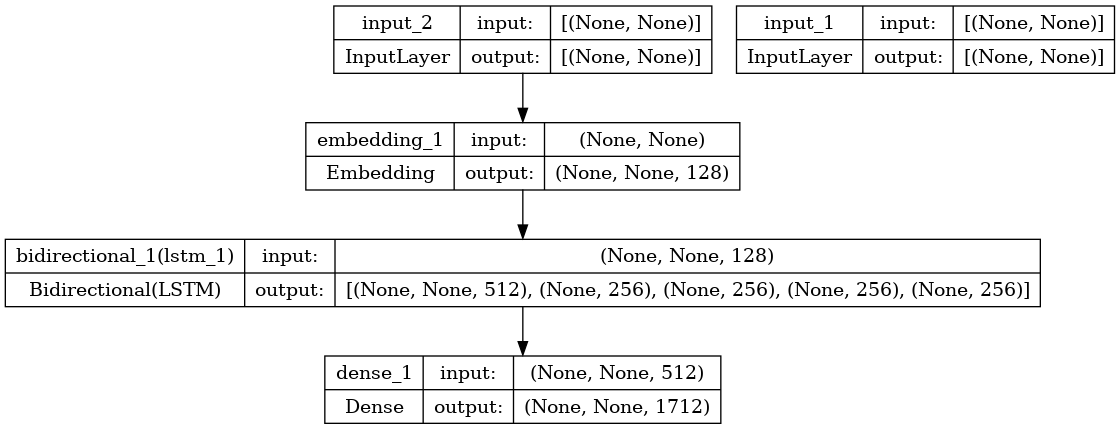

In [49]:
from tensorflow.keras.utils import plot_model

# Plot the model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [30]:
history = model.fit(
    [english_train, urdu_train],
    urdu_train,
    validation_data=([english_val, urdu_val], urdu_val),
    batch_size=64,
    epochs=10 )

Epoch 1/10
132/132 [==============================] - 22s 112ms/step - loss: 2.6174 - accuracy: 0.6554 - val_loss: 2.0991 - val_accuracy: 0.6639
Epoch 2/10
132/132 [==============================] - 4s 30ms/step - loss: 1.9524 - accuracy: 0.6774 - val_loss: 1.8075 - val_accuracy: 0.6910
Epoch 3/10
132/132 [==============================] - 3s 24ms/step - loss: 1.5687 - accuracy: 0.7357 - val_loss: 1.3257 - val_accuracy: 0.7750
Epoch 4/10
132/132 [==============================] - 3s 19ms/step - loss: 1.0522 - accuracy: 0.8134 - val_loss: 0.8174 - val_accuracy: 0.8513
Epoch 5/10
132/132 [==============================] - 3s 24ms/step - loss: 0.5851 - accuracy: 0.8974 - val_loss: 0.4091 - val_accuracy: 0.9356
Epoch 6/10
132/132 [==============================] - 3s 20ms/step - loss: 0.2633 - accuracy: 0.9626 - val_loss: 0.1808 - val_accuracy: 0.9780
Epoch 7/10
132/132 [==============================] - 2s 16ms/step - loss: 0.1144 - accuracy: 0.9879 - val_loss: 0.0842 - val_accuracy: 0.99

In [32]:
# Evaluate the model on the validation set
loss, accuracy = model.evaluate(x=[english_val, urdu_val], y=urdu_val)
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")

66/66 [==============================] - 1s 8ms/step - loss: 0.0153 - accuracy: 0.9996
Loss: 0.015289520844817162
Accuracy: 0.9996373653411865


In [34]:
model.save_weights('rnn_weights.h5')

In [35]:
model.save('rnn.h5')

In [50]:
from tensorflow.keras.models import load_model

model = load_model('/kaggle/working/rnn.h5')
